# Radiocarbon

In this tutorial, we will simulate the radiocarbon age using the AIBECS by
1. defining the transport `T(p)` and the sources and sinks `G(x,p)`,
1. defining the parameters `p`,
1. generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated radiocarbon age.

> *Note*
> Although this tutorial is self-contained, it involves non-linearitiess and is slightly more complicated than the first tutorial for simulating the ideal age.
> (So do not hesitate to start with the ideal-age tutorial if you wish.)

The tracer equation for radiocarbon is

$$\big(\partial_t + \mathbf{T} \big) \boldsymbol{R} = \frac{\lambda}{h} (\overline{\boldsymbol{R}}_\mathsf{atm} - \boldsymbol{R}) (\boldsymbol{z} ≤ h) - \boldsymbol{R} / \tau.$$

where the first term on the right of the equal sign represents the air–sea gas exchange with a piston velocity $λ$ over a depth $h$ and the second term represents the radioactive decay of radiocarbon with timescale $\tau$.

> Note:
> We need not specify the value of the atmospheric radiocarbon concentration because it is not important for determining the age of a water parcel — only the relative concentration $\boldsymbol{R}/\overline{\boldsymbol{R}}_\mathsf{atm}$ matters.

We start by selecting the circulation for Radiocarbon.
.)
(And this time, we are using the OCCA matrix by *Forget* [1](https://doi.org/10.1175/2009JPO4043.1).)

In [1]:
using AIBECS
grd, T_OCCA = OCCA.load()
T(p) = T_OCCA

┌ Warning: Over-writing registration of the datadep
│   name = AIBECS-OCCA
└ @ DataDeps /Users/runner/.julia/packages/DataDeps/gbyoa/src/registration.jl:15
┌ Info: You are about to use the OCCA model.
│ If you use it for research, please cite:
│ 
│ - Forget, G., 2010: Mapping Ocean Observations in a Dynamical Framework: A 2004–06 Ocean Atlas. J. Phys. Oceanogr., 40, 1201–1221, https://doi.org/10.1175/2009JPO4043.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "Forget_2010" key.)
└ @ AIBECS.OCCA /Users/runner/work/AIBECS.jl/AIBECS.jl/src/OCCA.jl:84


T (generic function with 1 method)

The local sources and sinks are simply given by

In [2]:
function G(R,p)
    @unpack λ, h, R̅atm, τ = p
    return @. λ / h * (R̅atm - R) * (z ≤ h) - R / τ
end

G (generic function with 1 method)

We can define `z` via

In [3]:
z = depthvec(grd)

84661-element Array{Float64,1}:
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
   25.0
    ⋮
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25
 5062.25

In this tutorial we will specify some units for the parameters.
Such features **must** be imported to be used

In [4]:
import AIBECS: @units, units

We define the parameters using the dedicated API from the AIBECS, including keyword arguments and units this time

In [5]:
@units struct RadiocarbonParameters{U} <: AbstractParameters{U}
    λ::U    | u"m/yr"
    h::U    | u"m"
    τ::U    | u"yr"
    R̅atm::U | u"M"
end

units (generic function with 20 methods)

For the air–sea gas exchange, we use a constant piston velocity $\lambda$ of 50m / 10years.
And for the radioactive decay we use a timescale $\tau$ of 5730/log(2) years.

In [6]:
p = RadiocarbonParameters(λ = 50u"m"/10u"yr",
                          h = grd.δdepth[1],
                          τ = 5730u"yr"/log(2),
                          R̅atm = 42.0u"nM")


│ Row │ Symbol │ Value   │ Unit     │
│     │ Symbol │ Float64 │ FreeUni… │
├─────┼────────┼─────────┼──────────┤
│ 1   │ λ      │ 5.0     │ m yr⁻¹   │
│ 2   │ h      │ 50.0    │ m        │
│ 3   │ τ      │ 8266.64 │ yr       │
│ 4   │ R̅atm   │ 4.2e-8  │ M        │

> *Note*
> The parameters are converted to SI units when unpacked.
>  When you specify units for your parameters, you must supply their values in that unit.

We generate the state function and its Jacobian, generate the corresponding steady-state problem, and solve it, via

In [7]:
F, ∇ₓF = state_function_and_Jacobian(T, G)
x = zeros(length(z)) # an initial guess
prob = SteadyStateProblem(F, ∇ₓF, x, p)
R = solve(prob, CTKAlg()).u

84661-element Array{Float64,1}:
 3.7813682936931614e-5
 3.775789970720418e-5
 3.660570790298639e-5
 3.707009029891958e-5
 3.71574479747527e-5
 3.715839927278402e-5
 3.707936439247628e-5
 3.714928379900505e-5
 3.723285923778982e-5
 3.7354960954900236e-5
 ⋮
 3.6384934143834534e-5
 3.638153292381402e-5
 3.6373088989200624e-5
 3.638148729939719e-5
 3.641671381562889e-5
 3.645599798864902e-5
 3.650695782714459e-5
 3.652218255431876e-5
 3.6535884095671667e-5

This should take a few seconds on a laptop.
Once the radiocarbon concentration is computed, we can convert it into the corresponding age in years, via

In [8]:
@unpack τ, R̅atm = p
C14age = @. log(R̅atm / R) * τ * u"s" |> u"yr"

84661-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(yr,),𝐓,nothing}},1}:
  867.9858872976661 yr
  880.1899484003425 yr
 1136.3776304296596 yr
 1032.1660922537947 yr
 1012.7082189815706 yr
 1012.4965806538729 yr
 1030.0982249324406 yr
 1014.5247521963072 yr
  995.9480200992284 yr
  968.8826854823169 yr
                     ⋮
 1186.3857759508144 yr
 1187.1585679088032 yr
 1189.0774285373682 yr
 1187.1689347337622 yr
  1179.168598531884 yr
 1170.2558452942346 yr
 1158.7084282581366 yr
  1155.261656759575 yr
 1152.1609520259306 yr

and plot it at 700 m using the `horizontalslice` Plots recipe

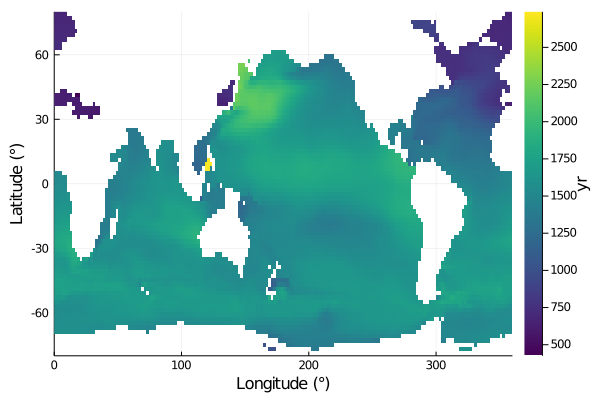

In [9]:
using Plots
plothorizontalslice(C14age, grd, depth=700u"m", color=:viridis)

look at a zonal average using the `zonalaverage` plot recipe

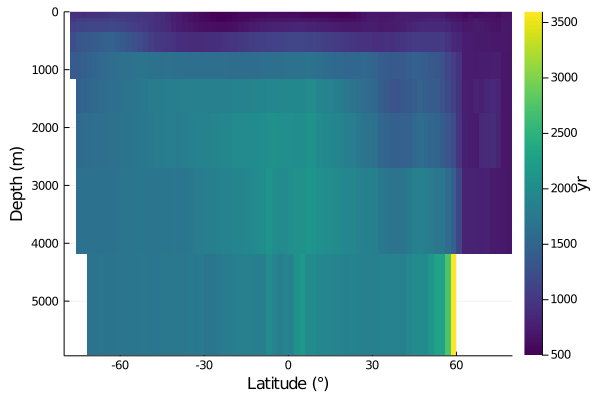

In [10]:
plotzonalaverage(C14age, grd; color=:viridis)

or look at a meridional slice through the Atlantic at 30°W using the `meridionalslice` plot recipe

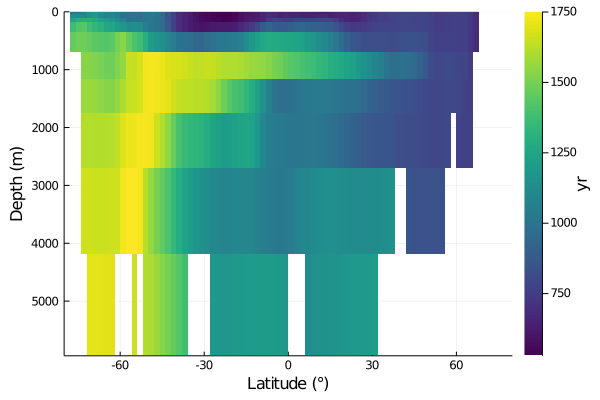

In [11]:
plotmeridionalslice(C14age, grd, lon=-30, color=:viridis)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*